# FloPy MODPATH 7 unstructured steady-state model with lateral flow boundaries

This notebook demonstrates example 4 from the MODPATH 7 documentation, a steady-state MODFLOW 6 simulation using a quadpatch DISV grid with an irregular domain and a large number of inactive cells. Particles are tracked backwards from terminating locations, including a pair of wells in a locally-refined region of the grid and constant-head cells along the grid's right side, to release locations along the left border of the grid's active region. Injection wells along the left-hand border are used to generate boundary flows.

First import FloPy and set up a temporary workspace.

In [14]:
import sys
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

proj_root = Path.cwd().parent.parent

# run installed version of flopy or add local path
try:
    import flopy
except:
    sys.path.append(proj_root)
    import flopy


temp_dir = TemporaryDirectory()
workspace = Path(temp_dir.name)
sim_name = "ex04_mf6"

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("Matplotlib version:", mpl.__version__)
print("FloPy version:", flopy.__version__)

Python version: 3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
NumPy version: 1.24.1
Matplotlib version: 3.6.3
FloPy version: 3.3.7


## Grid creation/refinement

In this example we use GRIDGEN to create a quadpatch grid with a refined region in the upper left quadrant.

The grid has 3 nested refinement levels, all nearly but not perfectly rectangular (a 500x500 area is carved out of each corner of each). Outer levels of refinement have a width of 500. To produce this pattern we use 5 rectangular polygons for each level.

First, create the coarse-grained grid discretization.

In [15]:
nlay, nrow, ncol = 1, 21, 26  # coarsest-grained grid is 21x26
delr = delc = 500.0
top = 100.0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Next, refine the grid. Create a `Gridgen` object from the base grid, then add refinement features (3 groups of polygons).

In [16]:
from flopy.utils.gridgen import Gridgen

# create Gridgen workspace
gridgen_ws = workspace / "gridgen"
gridgen_ws.mkdir()

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws=gridgen_ws)

# add polygon for each refinement level
outer_polygon = [
    [
        (2500, 6000),
        (2500, 9500),
        (3000, 9500),
        (3000, 10000),
        (6000, 10000),
        (6000, 9500),
        (6500, 9500),
        (6500, 6000),
        (6000, 6000),
        (6000, 5500),
        (3000, 5500),
        (3000, 6000),
        (2500, 6000),
    ]
]
g.add_refinement_features([outer_polygon], "polygon", 1, range(nlay))
refshp0 = gridgen_ws / "rf0"

middle_polygon = [
    [
        (3000, 6500),
        (3000, 9000),
        (3500, 9000),
        (3500, 9500),
        (5500, 9500),
        (5500, 9000),
        (6000, 9000),
        (6000, 6500),
        (5500, 6500),
        (5500, 6000),
        (3500, 6000),
        (3500, 6500),
        (3000, 6500),
    ]
]
g.add_refinement_features([middle_polygon], "polygon", 2, range(nlay))
refshp1 = gridgen_ws / "rf1"

inner_polygon = [
    [
        (3500, 7000),
        (3500, 8500),
        (4000, 8500),
        (4000, 9000),
        (5000, 9000),
        (5000, 8500),
        (5500, 8500),
        (5500, 7000),
        (5000, 7000),
        (5000, 6500),
        (4000, 6500),
        (4000, 7000),
        (3500, 7000),
    ]
]
g.add_refinement_features([inner_polygon], "polygon", 3, range(nlay))
refshp2 = gridgen_ws / "rf2"

Create and plot the refined grid with refinement levels superimposed.

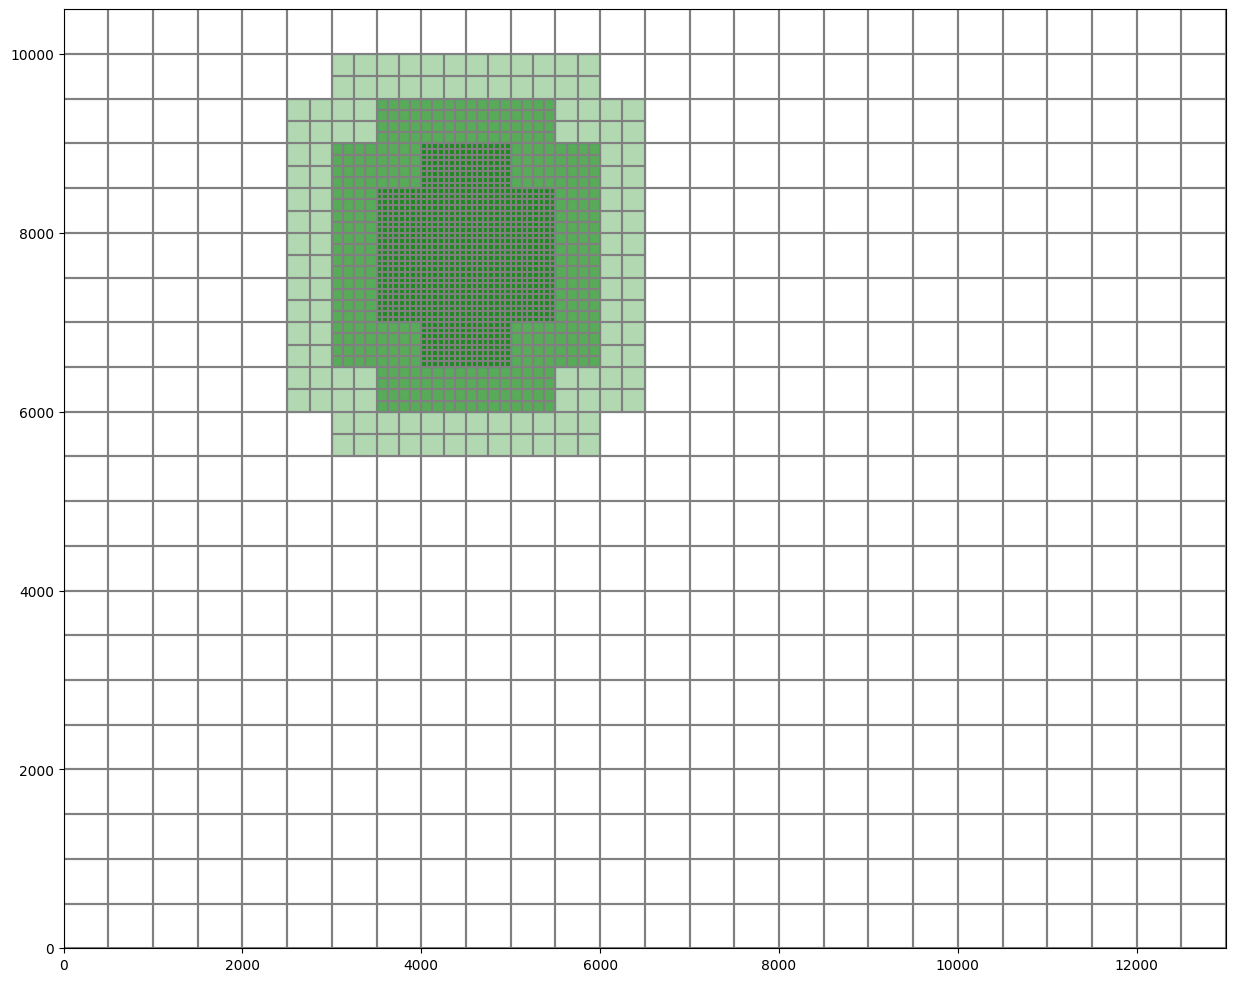

In [17]:
g.build(verbose=False)
grid = flopy.discretization.VertexGrid(**g.get_gridprops_vertexgrid())

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(model=ms)
grid.plot(ax=ax)
flopy.plot.plot_shapefile(refshp0, ax=ax, facecolor="green", alpha=0.3)
flopy.plot.plot_shapefile(refshp1, ax=ax, facecolor="green", alpha=0.5)
flopy.plot.plot_shapefile(str(refshp2), ax=ax, facecolor="green", alpha=0.7)

## Groundwater flow model

Next, create a GWF model. The particle-tracking model will consume its output.

In [18]:
# simulation
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name, sim_ws=workspace, exe_name="mf6", version="mf6"
)

# temporal discretization
tdis = flopy.mf6.ModflowTdis(
    sim, time_units="days", nper=1, perioddata=[(10000, 1, 1.0)]
)

# iterative model solver
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
    outer_dvclose=1e-4,
    outer_maximum=100,
    inner_dvclose=1e-5,
    under_relaxation_theta=0,
    under_relaxation_kappa=0,
    under_relaxation_gamma=0,
    under_relaxation_momentum=0,
    linear_acceleration="BICGSTAB",
    relaxation_factor=0.99,
    number_orthogonalizations=2,
)

# groundwater flow model
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=sim_name, model_nam_file=f"{sim_name}.nam", save_flows=True
)

# grid discretization
idomain = [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
]
disv_props = g.get_gridprops_disv()
disv = flopy.mf6.ModflowGwfdisv(
    gwf, length_units="feet", idomain=idomain, **disv_props
)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, strt=150.0)

# wells (layer, node number, q, iface)
wells = [
    # negative q: discharge
    (0, 861, -30000.0, 0),
    (0, 891, -30000.0, 0),
    # positive q: injection
    (0, 1959, 10000.0, 1),
    (0, 1932, 10000.0, 3),
    (0, 1931, 10000.0, 3),
    (0, 1930, 5000.0, 1),
    (0, 1930, 5000.0, 3),
    (0, 1903, 5000.0, 1),
    (0, 1903, 5000.0, 3),
    (0, 1876, 10000.0, 3),
    (0, 1875, 10000.0, 3),
    (0, 1874, 5000.0, 1),
    (0, 1874, 5000.0, 3),
    (0, 1847, 10000.0, 3),
    (0, 1847, 10000.0, 3),
    (0, 1846, 5000.0, 1),
    (0, 1846, 5000.0, 3),
    (0, 1845, 5000.0, 1),
    (0, 1845, 5000.0, 3),
    (0, 1818, 5000.0, 1),
    (0, 1818, 5000.0, 3),
    (0, 1792, 10000.0, 1),
    (0, 1766, 10000.0, 1),
    (0, 1740, 5000.0, 1),
    (0, 1740, 5000.0, 4),
    (0, 1715, 5000.0, 1),
    (0, 1715, 5000.0, 4),
    (0, 1690, 10000.0, 1),
    (0, 1646, 5000.0, 1),
    (0, 1646, 5000.0, 4),
    (0, 1549, 5000.0, 1),
    (0, 1549, 5000.0, 4),
    (0, 1332, 5000.0, 1),
    (0, 1332, 5000.0, 4),
    (0, 1021, 2500.0, 1),
    (0, 1021, 2500.0, 4),
    (0, 1020, 5000.0, 1),
    (0, 708, 2500.0, 1),
    (0, 708, 2500.0, 4),
    (0, 711, 625.0, 1),
    (0, 711, 625.0, 4),
    (0, 710, 625.0, 1),
    (0, 710, 625.0, 4),
    (0, 409, 1250.0, 1),
    (0, 407, 625.0, 1),
    (0, 407, 625.0, 4),
    (0, 402, 625.0, 1),
    (0, 402, 625.0, 4),
    (0, 413, 1250.0, 1),
    (0, 411, 1250.0, 1),
    (0, 203, 1250.0, 1),
    (0, 203, 1250.0, 4),
    (0, 202, 1250.0, 1),
    (0, 202, 1250.0, 4),
    (0, 199, 2500.0, 1),
    (0, 197, 1250.0, 1),
    (0, 197, 1250.0, 4),
    (0, 96, 2500.0, 1),
    (0, 97, 1250.0, 1),
    (0, 97, 1250.0, 4),
    (0, 107, 1250.0, 1),
    (0, 107, 1250.0, 4),
    (0, 103, 1250.0, 1),
    (0, 103, 1250.0, 4),
    (0, 102, 1250.0, 1),
    (0, 102, 1250.0, 4),
    (0, 43, 2500.0, 1),
    (0, 43, 2500.0, 4),
    (0, 44, 2500.0, 1),
    (0, 44, 2500.0, 4),
    (0, 45, 5000.0, 4),
    (0, 10, 10000.0, 1),
]
flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
    gwf,
    maxbound=68,
    auxiliary="IFACE",
    save_flows=True,
    stress_period_data={0: wells},
)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=True,
    save_flows=True,
    save_specific_discharge=True,
    icelltype=[0],
    k=[50],
)

# constant head boundary (period, node number, head)
chd_bound = [
    (0, 1327, 150.0),
    (0, 1545, 150.0),
    (0, 1643, 150.0),
    (0, 1687, 150.0),
    (0, 1713, 150.0),
]
chd = flopy.mf6.ModflowGwfchd(
    gwf, pname="chd", save_flows=True, stress_period_data=chd_bound
)

# output control
budget_file = f"{sim_name}.bud"
head_file = f"{sim_name}.hds"
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord=[budget_file],
    head_filerecord=[head_file],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

Before running the simulation, view the model's boundary conditions.

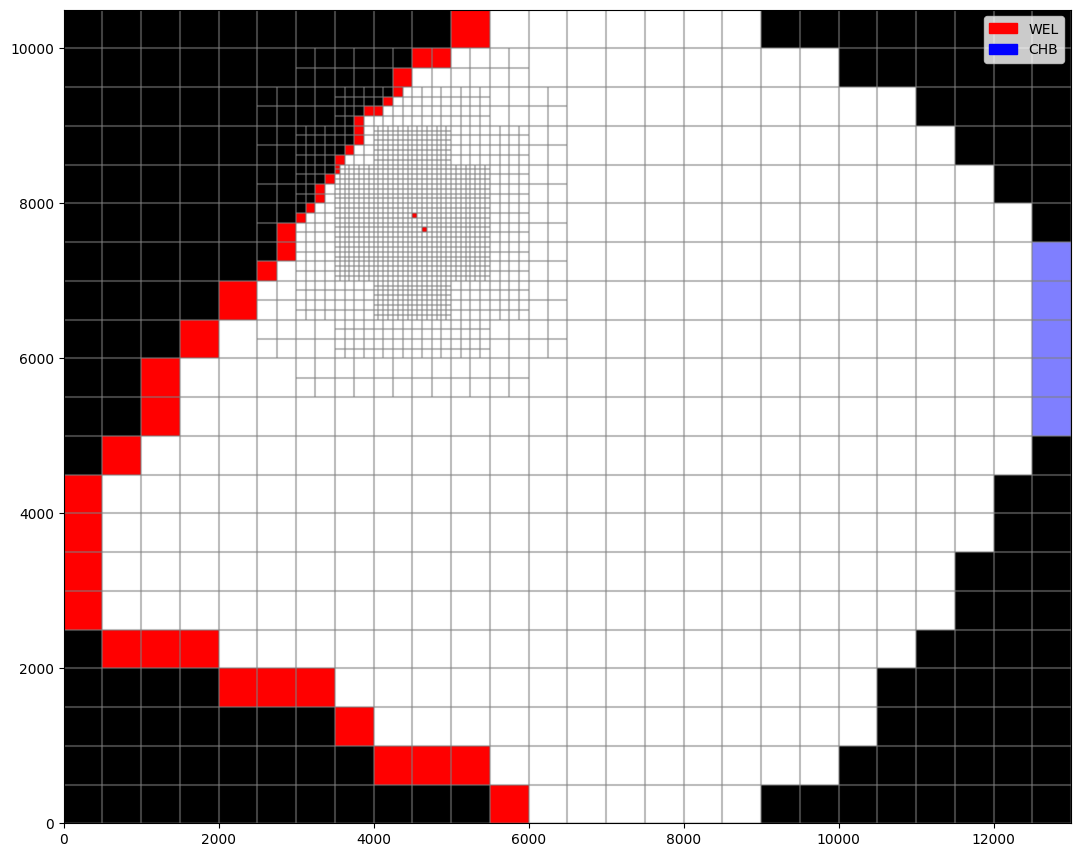

In [19]:
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mv = flopy.plot.PlotMapView(model=gwf, ax=ax)
mv.plot_grid(alpha=0.3)
mv.plot_ibound()
mv.plot_bc("WEL")
ax.add_patch(
    mpl.patches.Rectangle(
        ((ncol - 1) * delc, (nrow - 6) * delr),
        1000,
        -2500,
        linewidth=5,
        facecolor="blue",
        alpha=0.5,
    )
)
ax.legend(
    handles=[
        mpl.patches.Patch(color="red", label="WEL"),
        mpl.patches.Patch(color="blue", label="CHB"),
    ]
)

plt.show()

Run the simulation.

In [20]:
sim.set_sim_path(workspace)
sim.write_simulation()
success, buff = sim.run_simulation(silent=True, report=True)
assert success, f"Failed to run MF6 simulation."
for line in buff:
    print(line)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model ex04_mf6...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 72 based on size of stress_period_data
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 5 based on size of stress_period_data
    writing package oc...
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 04:48:56 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 


## Particle tracking


This example is a reverse-tracking model, with termination and release zones inverted: we "release" particles from the constant head boundary on the grid's right edge and from the two pumping wells, and track the particles backwards to release locations at the wells along the left boundary of the active domain.

In [ ]:
particles = [
    # node number, localx, localy, localz
    (1327, 0.000, 0.125, 0.500),
    (1327, 0.000, 0.375, 0.500),
    (1327, 0.000, 0.625, 0.500),
    (1327, 0.000, 0.875, 0.500),
    (1545, 0.000, 0.125, 0.500),
    (1545, 0.000, 0.375, 0.500),
    (1545, 0.000, 0.625, 0.500),
    (1545, 0.000, 0.875, 0.500),
    (1643, 0.000, 0.125, 0.500),
    (1643, 0.000, 0.375, 0.500),
    (1643, 0.000, 0.625, 0.500),
    (1643, 0.000, 0.875, 0.500),
    (1687, 0.000, 0.125, 0.500),
    (1687, 0.000, 0.375, 0.500),
    (1687, 0.000, 0.625, 0.500),
    (1687, 0.000, 0.875, 0.500),
    (1713, 0.000, 0.125, 0.500),
    (1713, 0.000, 0.375, 0.500),
    (1713, 0.000, 0.625, 0.500),
    (1713, 0.000, 0.875, 0.500),
    (861, 0.000, 0.125, 0.500),
    (861, 0.000, 0.375, 0.500),
    (861, 0.000, 0.625, 0.500),
    (861, 0.000, 0.875, 0.500),
    (861, 1.000, 0.125, 0.500),
    (861, 1.000, 0.375, 0.500),
    (861, 1.000, 0.625, 0.500),
    (861, 1.000, 0.875, 0.500),
    (861, 0.125, 0.000, 0.500),
    (861, 0.375, 0.000, 0.500),
    (861, 0.625, 0.000, 0.500),
    (861, 0.875, 0.000, 0.500),
    (861, 0.125, 1.000, 0.500),
    (861, 0.375, 1.000, 0.500),
    (861, 0.625, 1.000, 0.500),
    (861, 0.875, 1.000, 0.500),
    (891, 0.000, 0.125, 0.500),
    (891, 0.000, 0.375, 0.500),
    (891, 0.000, 0.625, 0.500),
    (891, 0.000, 0.875, 0.500),
    (891, 1.000, 0.125, 0.500),
    (891, 1.000, 0.375, 0.500),
    (891, 1.000, 0.625, 0.500),
    (891, 1.000, 0.875, 0.500),
    (891, 0.125, 0.000, 0.500),
    (891, 0.375, 0.000, 0.500),
    (891, 0.625, 0.000, 0.500),
    (891, 0.875, 0.000, 0.500),
    (891, 0.125, 1.000, 0.500),
    (891, 0.375, 1.000, 0.500),
    (891, 0.625, 1.000, 0.500),
    (891, 0.875, 1.000, 0.500),
]

pd = flopy.modpath.ParticleData(
    partlocs=[p[0] for p in particles],
    localx=[p[1] for p in particles],
    localy=[p[2] for p in particles],
    localz=[p[3] for p in particles],
    timeoffset=0,
    drape=0,
)
pg = flopy.modpath.ParticleGroup(
    particlegroupname="G1", particledata=pd, filename=f"{sim_name}.sloc"
)

Create and run the backwards particle tracking model in `pathline` mode.

In [ ]:
mp = flopy.modpath.Modpath7(
    modelname=sim_name + "_mp",
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=workspace,
)
mpbas = flopy.modpath.Modpath7Bas(
    mp,
    porosity=0.1,
)
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="pathline",
    trackingdirection="backward",
    budgetoutputoption="summary",
    particlegroups=[pg],
)

mp.write_input()
success, buff = mp.run_model(silent=True, report=True)
assert success, "Failed to run particle-tracking model."
for line in buff:
    print(line)

Load pathline data from the model's pathline output file.

In [ ]:
fpth = workspace / f"{sim_name}_mp.mppth"
p = flopy.utils.PathlineFile(fpth)
pl = p.get_destination_pathline_data(
    range(gwf.modelgrid.nnodes), to_recarray=True
)

Load head data.

In [ ]:
hf = flopy.utils.HeadFile(workspace / f"{sim_name}.hds")
hd = hf.get_data()

Plot heads and particle paths over the grid.

In [ ]:
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(model=gwf)
mm.plot_grid(lw=0.5, alpha=0.5)
mm.plot_ibound()
mm.plot_array(hd, alpha=0.5)
mm.plot_pathline(pl, layer="all", lw=0.3, colors=["black"])
plt.show()

Clean up the temporary workspace.

In [ ]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass